# Let's load some libraries

In [1]:
# This are just some graphical parameters to obtain the same figures that are in the paper.
library('ggplot2')
library('latex2exp')
library('gridExtra')
library('cowplot')
library('ggnewscale')

# clusters galaxies
c1 <- rgb(185/255, 18/255, 40/255,1)   #b91228
# backsplash
c2 <- rgb(255/255,133/255,27/255,1)    #ff851b
# infall 
c3 <- rgb(95/255, 75/255, 139/255,1)   #5f4b8b
# recent infallers
c4 <- rgb(61/255, 153/255, 112/255,1)  #3d9970
# interloopers
c5 <- '#808080'


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [2]:
library('ROGER')

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: caret

Loading required package: lattice

Loading required package: kernlab


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




[1] "Welcome to ROGER v1.0"

______________________________________________¶¶¶¶¶¶¶_______
____________________¶¶¶¶¶___________________¶¶¶¶____¶¶______
___________________¶¶¶¶¶¶¶_________________¶¶¶_______¶¶_____
____________________¶¶¶¶¶¶________________¶¶¶________¶¶_____
____________________¶¶¶¶¶_________________¶¶________¶¶______
__________________¶¶¶¶¶¶¶_________________¶¶_______¶¶¶______
_________________¶¶¶¶¶¶¶¶¶¶_______________¶¶_____¶¶¶________
________________¶¶¶¶¶__¶¶¶¶¶¶_____________¶¶__¶¶¶¶¶_________
______________¶¶¶¶¶¶¶___¶¶¶¶¶¶¶__________¶¶¶¶¶¶¶____________
______________¶¶¶¶¶¶¶¶¶___¶¶¶¶¶¶¶¶______¶¶¶¶¶_______________
_____________¶¶¶¶__¶¶¶¶¶¶____¶¶¶¶¶¶¶¶¶¶¶¶¶¶_________________
____________¶¶¶¶¶____¶¶¶¶¶¶¶____¶¶¶¶¶¶¶¶¶¶__________________
____________¶¶¶¶_______¶¶¶¶¶¶¶¶¶_____¶¶¶____________________
____________¶¶¶¶__________¶¶¶¶¶¶¶¶¶¶¶¶¶_____________________
____________¶¶¶¶_______________¶¶¶¶¶¶¶¶_____________________
_____________¶¶¶¶¶______________________________________

# Let's load the trainset

In [3]:
data(trainset)
summary(trainset)

     cum_id          gal_id            mas               r        
 Min.   : 1.00   Min.   :     1   Min.   : 9.170   Min.   :0.000  
 1st Qu.: 8.00   1st Qu.: 21053   1st Qu.: 9.440   1st Qu.:0.791  
 Median :16.00   Median : 44085   Median : 9.810   Median :1.452  
 Mean   :16.46   Mean   :103464   Mean   : 9.916   Mean   :1.516  
 3rd Qu.:25.00   3rd Qu.:204014   3rd Qu.:10.320   3rd Qu.:2.245  
 Max.   :34.00   Max.   :239985   Max.   :12.960   Max.   :3.000  
       v          flag1      flag2      fl1        fl2        fl3       
 Min.   :0.0000   X1: 3247   X0:16956   X0:25530   X0:24211   X0:21112  
 1st Qu.:0.2150   X2: 4566   X1:11821   X1: 3247   X1: 4566   X1: 7665  
 Median :0.4920   X3: 7665   X2:    0                                   
 Mean   :0.7686   X4: 2641                                              
 3rd Qu.:1.0480   X5:10658                                              
 Max.   :3.0000                                                         
 fl4        fl5     

In [4]:
# Let's separate the classes
cl0  <- subset(trainset, trainset$flag1 == 'X1') # Cluster galaxies
bs0  <- subset(trainset, trainset$flag1 == 'X2') # Backsplash galaxies
ing0 <- subset(trainset, trainset$flag1 == 'X3') # Infalling galaxies
rin0 <- subset(trainset, trainset$flag1 == 'X4') # Recent infalling galaxies
int0 <- subset(trainset, trainset$flag1 == 'X5') # Interlooper galaxies


In [5]:
# Let's load the ML models
data('knn') 
data('svm')
data('rf')

In [6]:
# Let's load the testing set
data(testCluster)
# Let's see the structure of this data frame
str(testCluster)
# Let's keep only with the 'r' and 'v' columns that will be used to predict, and
# save the real classification for future comparison.

cat        <- testCluster[, c(1, 2)]
real_class <- as.factor(testCluster$real_class)

'data.frame':	1067 obs. of  3 variables:
 $ r         : num  0.968 0.516 1.481 1.969 1.861 ...
 $ v         : num  0.422 1.953 1.197 1.105 0.717 ...
 $ real_class: Factor w/ 5 levels "X1","X2","X3",..: 3 5 5 5 5 3 5 5 5 5 ...


In [7]:
# Let's estimate the probabilities
prob_rf  <- get_class(cat, model = rf, type = 'prob')
prob_knn <- get_class(cat, model = knn, type = 'prob')
prob_svm <- get_class(cat, model = svm, type = 'prob')

In [8]:
# Let's perform a random classification of each galaxy taking into account it's probability
class_rf  <- 1:length(cat$r)
class_knn <- 1:length(cat$r)
class_svm <- 1:length(cat$r)

for(i in 1:length(cat$r)){
  class_rf[i]  <- sample(c('X1','X2','X3','X4','X5'), size = 1, prob = prob_rf[i,])
  class_knn[i] <- sample(c('X1','X2','X3','X4','X5'), size = 1, prob = prob_knn[i,])
  class_svm[i] <- sample(c('X1','X2','X3','X4','X5'), size = 1, prob = prob_svm[i,])
}

ran_test <- data.frame(cat, class_rf, class_knn, class_svm)

In [34]:
# Let's separete each class taking into account the svm method

cl  <- subset(ran_test, ran_test$class_svm == 'X1') # CLuster galaxies
bs  <- subset(ran_test, ran_test$class_svm == 'X2') # Backsplash galaxies
ing <- subset(ran_test, ran_test$class_svm == 'X3') # Infallin galaxies
rin <- subset(ran_test, ran_test$class_svm == 'X4') # Recent infalling galaxies
int <- subset(ran_test, ran_test$class_svm == 'X5') # Interlooper galaxies

p_svm <- ggplot(data = cl, aes(r, v))+
        theme_bw()+
        theme(text = element_text(family = "serif"),
              axis.text.x = element_text(size = 10),
              axis.text.y = element_text(size = 10)) +
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        labs(x = expression(paste(r/r[200])),
             y = expression(paste('|', Delta, V, '|/',sigma))) +

        geom_point(data = int, aes(r, v), shape = 19, size = 0.2, color = c5, alpha = 0.3) +
        geom_density_2d(data = ing, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low = rgb(1, 1, 1, 0.0), high = c3) +

        new_scale_fill() +
        geom_density_2d_filled(data = ing, aes(x = r, y = v, alpha = ..level.., 
                                               fill = ..level..), lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#d6cfe1','#aea1c4','#8675a7','#5f4b8b')) +
        
        new_scale_colour() +
        geom_density_2d(data = bs, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low = rgb(1,1,1,0.0), high = c2) +

        new_scale_fill() +
        geom_density_2d_filled(data = bs, aes(x = r , y = v, alpha = ..level.., fill = ..level..),
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#ffe0c7','#ffc291','#ffa45b','#ff851b')) +

        new_scale_colour() +
        geom_density_2d(data = rin, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low =  rgb(1,1,1,0.0), high = c4) +

        new_scale_fill() +
        geom_density_2d_filled(data = rin, aes(x = r, y = v, alpha = ..level.., fill = ..level..),
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#d0e5db','#a1ccb8','#72b296','#3d9976')) +

        new_scale_colour() +
        geom_density_2d(data = cl, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low =  rgb(1,1,1,0.0), high = c1) +

        new_scale_fill() +
        geom_density_2d_filled(data = cl, aes(x = r , y = v, alpha = ..level.., fill = ..level..), 
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#f7c9c4','#e8948c','#d35d58','#b91228')) +

        annotate(geom = 'text', x = 2.7, y = 3, label = 'SVM') +
        theme(legend.position="none")

        
hx_svm <- ggplot(data = cl,aes(r)) + 
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        theme_minimal() +
        theme(text = element_text(family = "serif"),
            axis.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 10)) +
        geom_density(color = c1, lwd = 1.5) +
        geom_density(data = bs, aes(r), color = c2, lwd = 1.) +
        geom_density(data = ing,aes(r), color = c3, lwd = 1.) +
        geom_density(data = rin,aes(r), color = c4, lwd = 1.) +
        geom_density(data = int,aes(r), color = c5, lwd = 1.) +
        geom_density(data = cl0, aes(r), color = c1, lwd = 0.5, lty = 2) +
        geom_density(data = bs0, aes(r), color = c2, lwd = 0.5, lty = 2) +
        geom_density(data = ing0, aes(r), color = c3, lwd = 0.5, lty = 2) +
        geom_density(data = rin0, aes(r), color = c4, lwd = 0.5, lty = 2) +
        geom_density(data = int0, aes(r), color = c5, lwd = 0.5, lty = 2)
    

    
hy_svm <- ggplot(data = cl,aes(v)) +
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        theme_minimal() +
        theme(text = element_text(family = "serif"),
            axis.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 10)) +
        geom_density(color = c1, lwd = 1.5) + 
        geom_density(data = bs, aes(v), color = c2, lwd = 1.5) + 
        geom_density(data = ing, aes(v), color = c3, lwd = 1.5) + 
        geom_density(data = rin, aes(v), color = c4, lwd = 1.5) + 
        geom_density(data = int, aes(v), color = c5, lwd = 1.5) + 
        geom_density(data = cl0, aes(v), color = c1, lwd = 0.5, lty = 2) +
        geom_density(data = bs0, aes(v), color = c2, lwd = 0.5, lty = 2) +
        geom_density(data = ing0, aes(v), color = c3, lwd = 0.5, lty = 2) +
        geom_density(data = rin0, aes(v), color = c4, lwd = 0.5, lty = 2) +
        geom_density(data = int0, aes(v), color = c5, lwd = 0.5, lty = 2) +
        coord_flip()

blankPlot <- ggplot() + geom_blank(aes(1, 1)) +
                theme(
                 plot.background  = element_blank(), 
                 panel.grid.major = element_blank(),
                 panel.grid.minor = element_blank(), 
                 panel.border = element_blank(),
                 panel.background = element_blank(),
                 axis.title.x = element_blank(),
                 axis.title.y = element_blank(),
                 axis.text.x = element_blank(), 
                 axis.text.y = element_blank(),
                 axis.ticks = element_blank(),
                 axis.line = element_blank()
                   )


In [32]:
# Let's separete each class taking into account the knn method

cl  <- subset(ran_test, ran_test$class_knn == 'X1') # CLuster galaxies
bs  <- subset(ran_test, ran_test$class_knn == 'X2') # Backsplash galaxies
ing <- subset(ran_test, ran_test$class_knn == 'X3') # Infallin galaxies
rin <- subset(ran_test, ran_test$class_knn == 'X4') # Recent infalling galaxies
int <- subset(ran_test, ran_test$class_knn == 'X5') # Interlooper galaxies

p_knn <- ggplot(data = cl, aes(r, v))+
        theme_bw()+
        theme(text = element_text(family = "serif"),
              axis.text.x = element_text(size = 10),
              axis.text.y = element_text(size = 10)) +
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        labs(x = expression(paste(r/r[200])),
             y = expression(paste('|', Delta, V, '|/',sigma))) +

        geom_point(data = int, aes(r, v), shape = 19, size = 0.2, color = c5, alpha = 0.3) +
        geom_density_2d(data = ing, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low = rgb(1, 1, 1, 0.0), high = c3) +

        new_scale_fill() +
        geom_density_2d_filled(data = ing, aes(x = r, y = v, alpha = ..level.., 
                                               fill = ..level..), lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#d6cfe1','#aea1c4','#8675a7','#5f4b8b')) +
        
        new_scale_colour() +
        geom_density_2d(data = bs, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low = rgb(1,1,1,0.0), high = c2) +

        new_scale_fill() +
        geom_density_2d_filled(data = bs, aes(x = r , y = v, alpha = ..level.., fill = ..level..),
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#ffe0c7','#ffc291','#ffa45b','#ff851b')) +

        new_scale_colour() +
        geom_density_2d(data = rin, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low =  rgb(1,1,1,0.0), high = c4) +

        new_scale_fill() +
        geom_density_2d_filled(data = rin, aes(x = r, y = v, alpha = ..level.., fill = ..level..),
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#d0e5db','#a1ccb8','#72b296','#3d9976')) +

        new_scale_colour() +
        geom_density_2d(data = cl, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low =  rgb(1,1,1,0.0), high = c1) +

        new_scale_fill() +
        geom_density_2d_filled(data = cl, aes(x = r , y = v, alpha = ..level.., fill = ..level..), 
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#f7c9c4','#e8948c','#d35d58','#b91228')) +

        annotate(geom = 'text', x = 2.7, y = 3, label = 'KNN') +
        theme(legend.position="none")
        
hx_knn <- ggplot(data = cl,aes(r)) + 
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        theme_minimal() +
        theme(text = element_text(family = "serif"),
            axis.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 10)) +
        geom_density(color = c1, lwd = 1.5) +
        geom_density(data = bs, aes(r), color = c2, lwd = 1.) +
        geom_density(data = ing,aes(r), color = c3, lwd = 1.) +
        geom_density(data = rin,aes(r), color = c4, lwd = 1.) +
        geom_density(data = int,aes(r), color = c5, lwd = 1.) +
        geom_density(data = cl0, aes(r), color = c1, lwd = 0.5, lty = 2) +
        geom_density(data = bs0, aes(r), color = c2, lwd = 0.5, lty = 2) +
        geom_density(data = ing0, aes(r), color = c3, lwd = 0.5, lty = 2) +
        geom_density(data = rin0, aes(r), color = c4, lwd = 0.5, lty = 2) +
        geom_density(data = int0, aes(r), color = c5, lwd = 0.5, lty = 2)
    

    
hy_knn <- ggplot(data = cl,aes(v)) +
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        theme_minimal() +
        theme(text = element_text(family = "serif"),
            axis.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 10)) +
        geom_density(color = c1, lwd = 1.5) + 
        geom_density(data = bs, aes(v), color = c2, lwd = 1.5) + 
        geom_density(data = ing, aes(v), color = c3, lwd = 1.5) + 
        geom_density(data = rin, aes(v), color = c4, lwd = 1.5) + 
        geom_density(data = int, aes(v), color = c5, lwd = 1.5) + 
        geom_density(data = cl0, aes(v), color = c1, lwd = 0.5, lty = 2) +
        geom_density(data = bs0, aes(v), color = c2, lwd = 0.5, lty = 2) +
        geom_density(data = ing0, aes(v), color = c3, lwd = 0.5, lty = 2) +
        geom_density(data = rin0, aes(v), color = c4, lwd = 0.5, lty = 2) +
        geom_density(data = int0, aes(v), color = c5, lwd = 0.5, lty = 2) +
        coord_flip()

In [35]:
# Let's separete each class taking into account the knn method

cl  <- subset(ran_test, ran_test$class_rf == 'X1') # CLuster galaxies
bs  <- subset(ran_test, ran_test$class_rf == 'X2') # Backsplash galaxies
ing <- subset(ran_test, ran_test$class_rf == 'X3') # Infallin galaxies
rin <- subset(ran_test, ran_test$class_rf == 'X4') # Recent infalling galaxies
int <- subset(ran_test, ran_test$class_rf == 'X5') # Interlooper galaxies

p_rf <- ggplot(data = cl, aes(r, v))+
        theme_bw()+
        theme(text = element_text(family = "serif"),
              axis.text.x = element_text(size = 10),
              axis.text.y = element_text(size = 10)) +
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        labs(x = expression(paste(r/r[200])),
             y = expression(paste('|', Delta, V, '|/',sigma))) +

        geom_point(data = int, aes(r, v), shape = 19, size = 0.2, color = c5, alpha = 0.3) +
        geom_density_2d(data = ing, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low = rgb(1, 1, 1, 0.0), high = c3) +

        new_scale_fill() +
        geom_density_2d_filled(data = ing, aes(x = r, y = v, alpha = ..level.., 
                                               fill = ..level..), lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#d6cfe1','#aea1c4','#8675a7','#5f4b8b')) +
        
        new_scale_colour() +
        geom_density_2d(data = bs, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low = rgb(1,1,1,0.0), high = c2) +

        new_scale_fill() +
        geom_density_2d_filled(data = bs, aes(x = r , y = v, alpha = ..level.., fill = ..level..),
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#ffe0c7','#ffc291','#ffa45b','#ff851b')) +

        new_scale_colour() +
        geom_density_2d(data = rin, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low =  rgb(1,1,1,0.0), high = c4) +

        new_scale_fill() +
        geom_density_2d_filled(data = rin, aes(x = r, y = v, alpha = ..level.., fill = ..level..),
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#d0e5db','#a1ccb8','#72b296','#3d9976')) +

        new_scale_colour() +
        geom_density_2d(data = cl, aes(x = r, y = v, colour = ..level..), lwd = 1, bins = 5) + 
        scale_colour_gradient(low =  rgb(1,1,1,0.0), high = c1) +

        new_scale_fill() +
        geom_density_2d_filled(data = cl, aes(x = r , y = v, alpha = ..level.., fill = ..level..), 
                               lwd = 1, bins = 5) + 
        scale_fill_manual(values = c('#ffffff','#f7c9c4','#e8948c','#d35d58','#b91228')) +

        annotate(geom = 'text', x = 2.7, y = 3, label = 'RF') +
        theme(legend.position="none")
        
hx_rf <- ggplot(data = cl,aes(r)) + 
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        theme_minimal() +
        theme(text = element_text(family = "serif"),
            axis.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 10)) +
        geom_density(color = c1, lwd = 1.5) +
        geom_density(data = bs, aes(r), color = c2, lwd = 1.) +
        geom_density(data = ing,aes(r), color = c3, lwd = 1.) +
        geom_density(data = rin,aes(r), color = c4, lwd = 1.) +
        geom_density(data = int,aes(r), color = c5, lwd = 1.) +
        geom_density(data = cl0, aes(r), color = c1, lwd = 0.5, lty = 2) +
        geom_density(data = bs0, aes(r), color = c2, lwd = 0.5, lty = 2) +
        geom_density(data = ing0, aes(r), color = c3, lwd = 0.5, lty = 2) +
        geom_density(data = rin0, aes(r), color = c4, lwd = 0.5, lty = 2) +
        geom_density(data = int0, aes(r), color = c5, lwd = 0.5, lty = 2)
    

    
hy_rf <- ggplot(data = cl,aes(v)) +
        scale_x_continuous(limits = c(0, 3), breaks = seq(0, 3, 0.5)) +
        theme_minimal() +
        theme(text = element_text(family = "serif"),
            axis.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 10)) +
        geom_density(color = c1, lwd = 1.5) + 
        geom_density(data = bs, aes(v), color = c2, lwd = 1.5) + 
        geom_density(data = ing, aes(v), color = c3, lwd = 1.5) + 
        geom_density(data = rin, aes(v), color = c4, lwd = 1.5) + 
        geom_density(data = int, aes(v), color = c5, lwd = 1.5) + 
        geom_density(data = cl0, aes(v), color = c1, lwd = 0.5, lty = 2) +
        geom_density(data = bs0, aes(v), color = c2, lwd = 0.5, lty = 2) +
        geom_density(data = ing0, aes(v), color = c3, lwd = 0.5, lty = 2) +
        geom_density(data = rin0, aes(v), color = c4, lwd = 0.5, lty = 2) +
        geom_density(data = int0, aes(v), color = c5, lwd = 0.5, lty = 2) +
        coord_flip()

In [39]:
pdf('../../backsplash/graph/final_06_07/random_classification_RF_TESTcluster.pdf')
grid.arrange(hx_rf, blankPlot, p_rf, hy_rf,
             ncol = 2, nrow = 2, widths = c(4, 1.4), heights = c(1.4, 4))
dev.off()

png 
  2

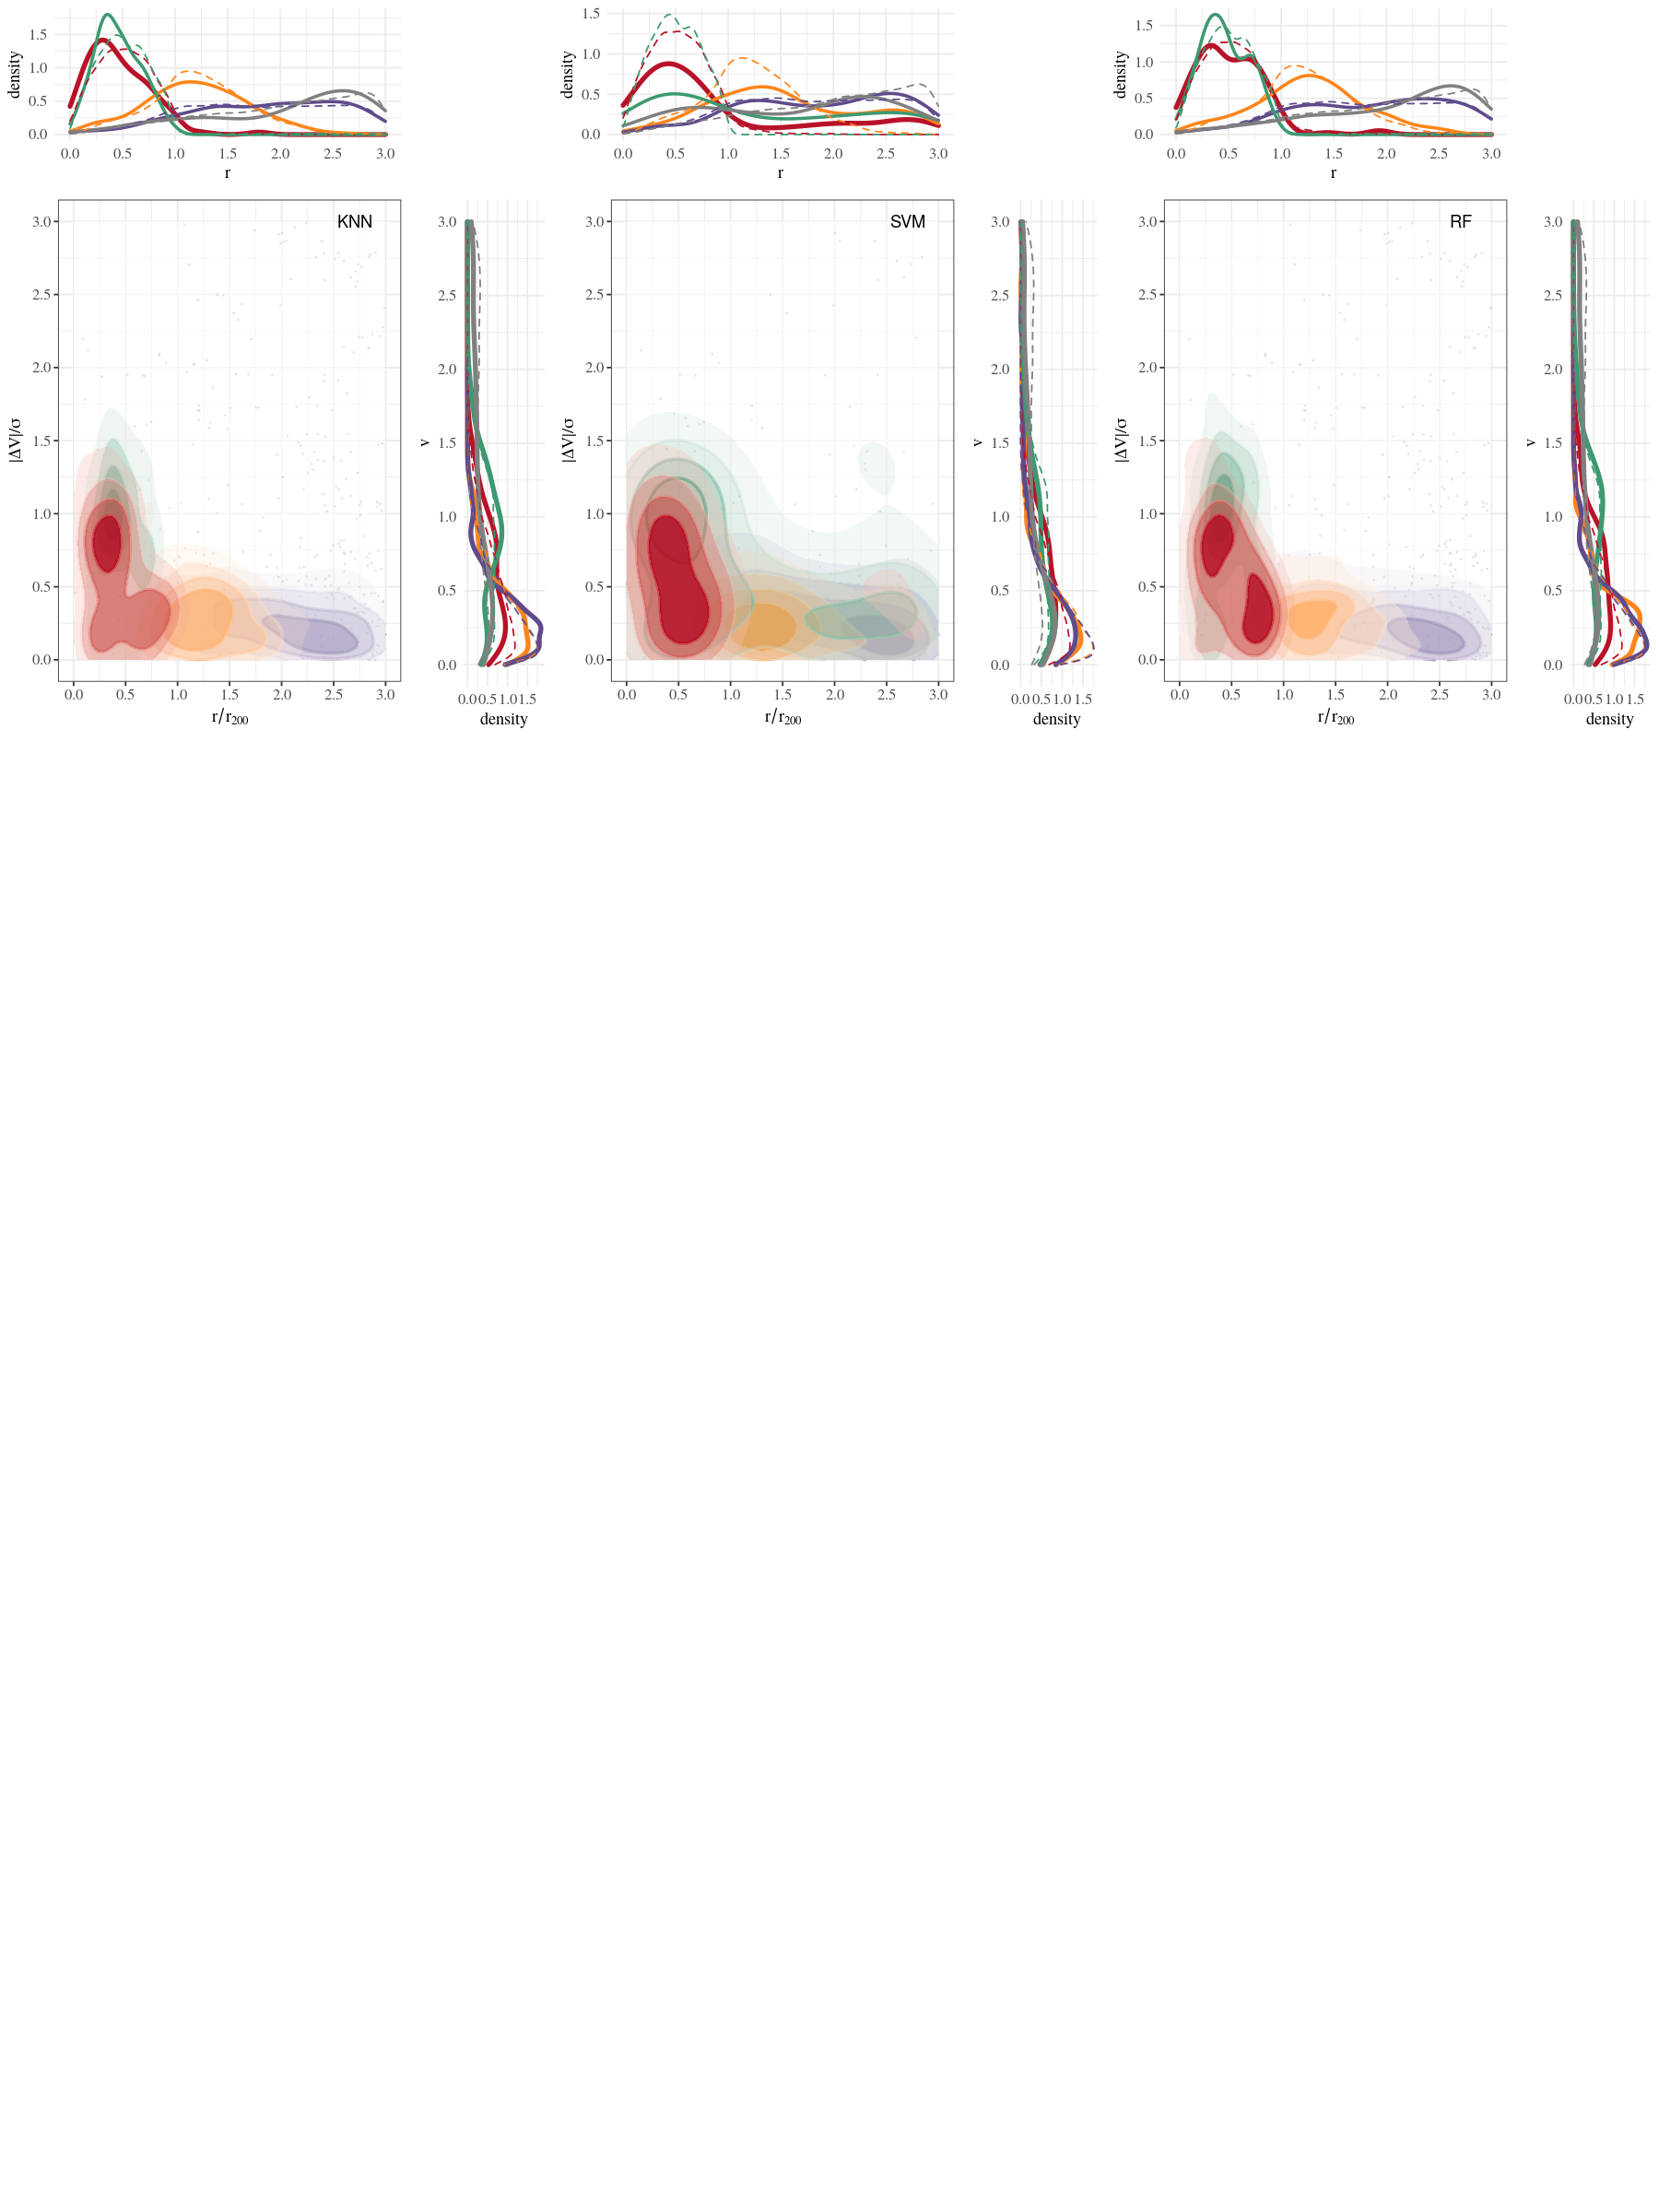

In [36]:
options(repr.plot.width = 15, repr.plot.height = 20)
grid.arrange(hx_knn, blankPlot, hx_svm, blankPlot, hx_rf, blankPlot, p_knn, hy_knn, p_svm, hy_svm, p_rf, hy_rf,
             ncol = 6, nrow = 6, widths = c(4, 1.4, 4, 1.4, 4, 1.4), heights = c(1.4, 4, 1.4, 4, 1.4, 4))